# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей.   

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;  
* Контролировать добросовестность кассиров при продаже алкоголя.

Требуется построить модель, которая по фотографии определит приблизительный возраст человека. 
Доступен набор фотографий людей с указанием возраста.

#### [Часть 1. Исследовательский анализ данных](#part1)

#### [Часть 2. Обучение модели](#part2)

#### [Часть 3. Анализ обученной модели](#part3)

<a id='part1'></a>
# 1. Исследовательский анализ данных

Импортируем библиотеки

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Загружаем данные

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Строим гистограмму возрастов и используем метод describe для отображения основных статистических характеристик.

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


Text(0.5, 1.0, 'Распределение возрастов')

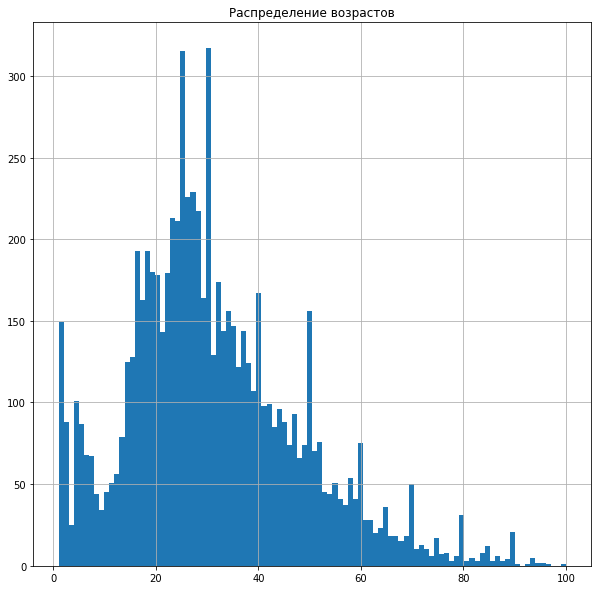

In [3]:
print(labels.describe())
labels.hist(bins=100,figsize=(10,10))
plt.title('Распределение возрастов')

(32, 224, 224, 3)


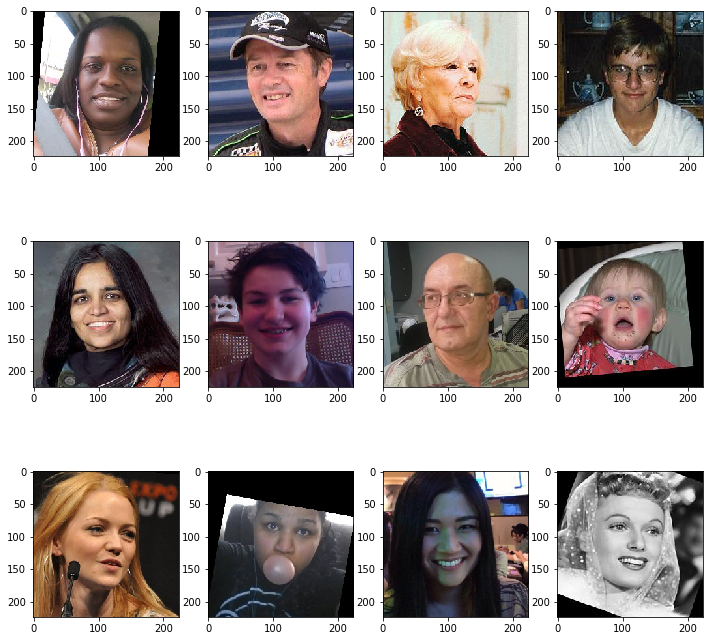

In [4]:
features, target = next(train_gen_flow)
print(features.shape) 

fig=plt.figure(figsize=(12, 12))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    img = features[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

### Вывод

В датасете всего находится 7591 изображение.  
Распределение возрастов похоже на нормальное, но оно ассиметрично (скошено вправо) и в нем присутсвуют выбросы в "круглых" значениях возраста (40, 50, 60...)  
Также в датасете присутсвует достаточно много фотографий детей до 10 лет, которые чаще всего клиентами супермаркета быть не могут.

<a id='part2'></a>
# 2. Обучение модели

```python
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

def load_train(path):
    
    train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)
    
    labels = pd.read_csv('/datasets/faces/labels.csv')
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 
       
    return train_datagen_flow


def load_test(path):
    
    val_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)    
    
    labels = pd.read_csv('/datasets/faces/labels.csv')
    
    valid_datagen_flow = val_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345)
  
    return valid_datagen_flow
  
    
    
    
def create_model(input_shape):

    optimizer = Adam(lr=0.0001)
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    model.compile(loss='mse', 
              optimizer=optimizer, metrics=['mae'])
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5, 
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
          validation_data=test_data,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          verbose=2, epochs=epochs)
    return model

```

```
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/5
178/178 - 124s - loss: 245.0773 - mae: 11.1763 - val_loss: 864.1383 - val_mae: 24.5263
Epoch 2/5
178/178 - 42s - loss: 61.6052 - mae: 5.9274 - val_loss: 553.9491 - val_mae: 18.0560
Epoch 3/5
178/178 - 42s - loss: 30.0473 - mae: 4.2222 - val_loss: 364.1774 - val_mae: 14.0362
Epoch 4/5
178/178 - 41s - loss: 19.0283 - mae: 3.3722 - val_loss: 107.1185 - val_mae: 7.8346
Epoch 5/5
178/178 - 41s - loss: 14.7888 - mae: 2.9670 - val_loss: 77.4031 - val_mae: 6.6732

60/60 - 10s - loss: 77.4031 - mae: 6.6732
Test MAE: 6.6732
```

<a id='part3'></a>
# 3. Анализ обученной модели

Была выбрана предобученная на ImageNet сеть ResNet с 50 слоями и с заново сконстурированной верхушкой.
Выходной слой состоит из одного нейрона с функцией активации ReLU (т.к. возраст может быть только положительным).

В результате обучения уже на 4 эпохах MAE на валидационной выборке стала меньше 8. 

Финальное полученное значение МАЕ составило 6.6732